## Numerical Solution of LWR model:

Lighthill-Whitham-Richards model (commonly used for traffic flow):

\begin{equation}
\frac{\partial q}{\partial x} + \frac{\partial k}{\partial t} = 0
\end{equation}

But $q$ is a function of $k$ (Greenshield model): 
$$
q(k) = k(k_j - k) = k k_j -k^2
$$

Therefore
$$
\frac{\partial k}{\partial t} + \frac{dq}{dk}\frac{\partial k}{\partial x} =0
$$

$$
\frac{d(q(k))}{dk} = 1(k_j - k) + k(-1) = k_j - 2k
$$

And
$$
\frac{\partial k}{\partial t} + (k_j - 2k) \frac{\partial k}{\partial x} = 0
$$

$$
\frac{\partial k}{\partial t} = (2k - k_j) \frac{\partial k}{\partial x}
$$

\begin{align}
k(t + \Delta t, x_n) =& k(t, x) + \Delta t \frac{\partial k}{\partial t} \\
                =& k(t, x) + \Delta t \left(2k(t, x) - k_j\right) \frac{\partial k}{\partial x}
\end{align}

\begin{align}
\frac{\partial{k}}{\partial x} \approx \frac{k(t, x + \Delta x) - k(t,x - \Delta x)}{2 \Delta x} \\
                               \approx \frac{k(t, x + \Delta x) - k(t, x)}{\Delta x} \\
\end{align}

If I remember correctly the central difference formula is unstable when used with the forward time step, 
but I will check into this.

Discretizing along t_i for i=0,$n_t$ and x_n for n=0, $n_x$.
$k_n^i$ equals the traffic density at time $t_i$ and position $n_i$.

Sampling rates are $\Delta t$ and $\Delta x$, respectively.
$k_j(x)$ is location dependent.  Call it $\kappa_n$.

$$
k_n^{i+1} = k_n^i + \Delta t  (2 k_n^i - \kappa_n) \frac{k_{n+1}^i - k_n^i}{\Delta x}
$$

In a real world scenario, we wouldn't have data at every point along the discretized distance.
This is different from the scenario tested before.  Therefore, the function needs to be modified
to internally calculate points with the discretization distance needed to fulfill the stability criterion, while outputting predictions only where data is available.

CFL condition:
\begin{equation}
\end{equation}

In [2]:
import numpy as np

In [3]:
nx=100
nt=1000
#kj = np.linspace(275/3600., 75/3600., nx)
kj = np.ones((nx,), dtype=float)*0.05
kj[50:60] = 0.01 #50/3600.

dx=0.1
dt=0.5
print(dt)

0.5


In [4]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
plotly.io.templates.default = 'plotly_dark'
from ipywidgets import widgets

In [5]:
import torch 
import torch.nn as nn
print(torch.__version__)

1.4.0


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"
#device = torch.device("cpu")
print(device)
import matplotlib.pyplot as plt
from tqdm import tqdm

cuda


In [58]:
class Neural_LWR_sparse2(nn.Module):
    def __init__(self, nx, dx, dt, kj, xi, tskip, initial='random'):
        self.nx = nx
        #xi are the locations along distance where data is available
        self.xi = xi
        self.tskip = tskip
            
        super(Neural_LWR_sparse2, self).__init__()
        if initial == 'random':
            #self.initial = torch.nn.Parameter(torch.rand(nx))
            self.initial = torch.rand(nx)
        elif initial == 'zeros':
            self.initial = torch.zeros(nx, requires_grad=True).double()
            self.initial[0] = kj[0] / 2.
        else:
            #self.initial = torch.nn.Parameter(initial)
            self.initial = torch.tensor(initial)
            
        #initial conditions
        #self.k[0] = self.initial
        
        self.kappa=torch.nn.Parameter(kj, requires_grad=True)
        
        #boundary conditions (traffic is at optimal density - hardcoded for now)
        #self.k[0:50,0] = self.kappa[0] / 2.
        self.dx = torch.tensor(dx)
        self.dt = torch.tensor(dt)
        
    def forward(self, tsteps):
        
        nt=len(tsteps)
        self.k=[self.initial]
        
        self.ki=[self.initial[self.xi]]
        ##self.k=torch.zeros((nt,nx), dtype=torch.double)
        #self.k=torch.zeros((nt,nx), requires_grad=True).double()
        #self.k[0:50,0]=self.kappa[0]/2.
        
        for n in range(1,nt):
            tmp1=2*self.k[n-1][1:] - self.kappa[1:]
            tmp2=(self.k[n-1][1:]-self.k[n-1][:-1]) / self.dx
            #tmp1=2*self.k[n-1,1:] - self.kappa[1:]
            #tmp2=(self.k[n-1,1:]-self.k[n-1,:-1]) / self.dx
            #nk=torch.DoubleTensor(nx)
            nk=torch.zeros(nx, requires_grad=True).double()
            if n < 50:
                nk[0] = self.kappa[0] / 2.
            else:
                nk[0] = 0.
            nk[1:]=self.k[n-1][1:] + self.dt*tmp1 * tmp2
            self.k.append(nk)
            #only output every tskip timesteps
            if (n % self.tskip) == 0:
                self.ki.append(nk[self.xi])
            #self.k[n,1:] = self.k[n-1,1:] + self.dt*tmp1 * tmp2
            #self.k.append(self.k[n][1:] + self.dt*(2*self.k[n][1:] - self.kappa[1:]) * \
            #    (self.k[n][1:]-self.k[n][:-1]) / self.dx)
            
        return torch.stack(self.ki)
        #return self.k

In [59]:
xi=[10,25,40,62,70,80,99]

In [60]:
tdn=Neural_LWR_sparse2(nx, dx, dt, torch.tensor(kj), xi, 10, initial='zeros')

In [82]:
steps=torch.tensor(np.linspace(0, 1000, 1001), requires_grad=True).float()
#steps=torch.tensor(np.linspace(0, 1, 1), requires_grad=True).float()
k=tdn(steps)
#np.linspace?
#tdn.k[99]
print(k.shape,nt, nx)

torch.Size([101, 7]) 1000 100


Text(0, 0.5, 'Traffic density')

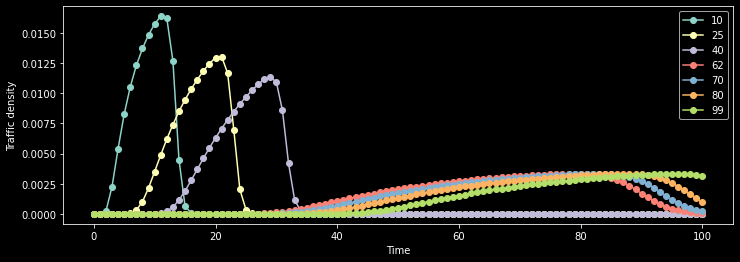

In [62]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

fig,ax=plt.subplots(figsize=(12,4))

for p in range(len(xi)):
    ax.plot(k[:,p].detach(), label=xi[p], marker='o')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Traffic density')

In [64]:
tdnu = Neural_LWR_sparse2(nx, dx, dt, torch.nn.Parameter(torch.tensor(kj/3.)), xi, 10, initial='zeros')
#y_exact = torch.stack(tdn.k).detach()
y_exact = k.detach()

optimizer = torch.optim.Adam(tdnu.parameters(), 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)

In [65]:
num_epochs = 300
loss_fun = torch.nn.MSELoss()
min_loss = 10

In [66]:
y_approx = tdnu(steps)
print(len(y_approx), len(y_exact))
loss=loss_fun(y_approx, y_exact)
#torch.cat(tdn.k, dim=1).shape
#torch.cat([torch.tensor(p) for p in tdn.k], dim=1).shape

101 101


In [67]:
#print(tdnu.k[0,0].grad)
#y_approx
#y_exact[-1,-1].backward(retain_graph=True)

In [68]:
#loss.backward(retain_graph=True)

In [69]:
tqdm_epochs = tqdm(range(num_epochs))
for e in tqdm_epochs:
    y_approx = tdnu(steps)
    loss = loss_fun(y_approx, y_exact)
    if loss.item() < min_loss:
        best_model_lwr = tdnu
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

100%|██████████| 300/300 [01:08<00:00,  4.37it/s, loss=4.71e-10]


In [70]:
#tdnu.kappa

In [71]:
#kj

In [72]:
#tdn.k[500]

In [73]:
#tdnu.k[500]

In [74]:
from matplotlib.pyplot import get_cmap
cm=get_cmap('OrRd')
cm(0.5, alpha=None)

(0.9874356016916571, 0.550480584390619, 0.34797385620915033, 1.0)

In [75]:
fig2 = make_subplots(rows=1, cols=1, subplot_titles=["Density","Flow","Velocity"],  shared_xaxes=True)

for p in range(len(xi)):
    clr=cm(p/len(xi))
    clrs="rgb(%d,%d,%d)" % (clr[0]*255, clr[1]*255, clr[2]*255)
    trace1=go.Scatter(y=y_exact[:,p].detach(), mode='lines', name=str(xi[p]), 
                      legendgroup=p, showlegend=True,
                      line=dict(width=5, color=clrs))
    sclr='black' if p < 4 else 'white'
    trace2=go.Scatter(y=y_approx[:,p].detach(), mode='lines', name=str(xi[p]),  
                      legendgroup=p, showlegend=False,
                      line=dict(width=2,dash='dot', color=sclr))
    fig2.add_trace(trace1, row=1, col=1)
    fig2.add_trace(trace2, row=1, col=1)
fig2

In [76]:
fig2.write_html('k_of_t_sparse.html')

In [77]:
"""
fig2,ax2=plt.subplots(figsize=(12,6))
for p in range(len(xi)):
    clr=cm(p/len(xi))
    ax2.plot(y_exact[:,p].detach(), label=xi[p], color=clr, linestyle='solid', linewidth=3)
    ax2.plot(y_approx[:,p].detach(), label=xi[p], color='white', linestyle='dotted')
ax2.legend()
""";

In [78]:
fig3=make_subplots()
#fig3.add_trace(go.Scatter(y=kj, name='$\\text{True} \ k_j$'))
#fig3.add_trace(go.Scatter(y=tdnu.kappa.detach(), name='$\\text{Estimated} \ k_j$', line=dict(dash='dash')))
fig3.add_trace(go.Scatter(y=kj, name='True'))
fig3.add_trace(go.Scatter(y=tdnu.kappa.detach(), name='Estimated', line=dict(dash='dash')))
fig3.add_trace(go.Scatter(x=xi, y=kj[xi], name='Sensors', mode='markers',
                         marker=dict(size=12)))
fig3.update_yaxes(title="k_j")
fig3.update_xaxes(title="Distance")

In [79]:
fig3.write_html("kj_estimate_sparse.html")